# Read Data From CSV

In [17]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from numpy.linalg import norm
from quaternion import Quaternion
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
import os
from os import walk
import madgwickahrs as mg
from quaternion import Quaternion

In [18]:
#функции калибровки
def find_offsets(mpu,counts = 15):
    calibration_set = mpu.loc[:counts]
    calibration_set =mpu 
    n = float(len(calibration_set))
    summ = []
    offsets = []
    for i in calibration_set:
        summ.append(calibration_set[i].sum())
    for s in summ:
        offsets.append(s/n)
    return offsets

def find_headers(mpu):
    headers = []
    for i in mpu:
        headers.append(i)
    return headers

def calibration(mpu,dataset):
    
    headers = find_headers(mpu)
#     print(headers)
    
    off = find_offsets(mpu)
    calibrated = dataset.copy()
    #не калибровать ускорение для фильтра маджвика!
    calibrated[headers[0]] = mpu[headers[0]] - off[0]
#     calibrated[headers[1]] = mpu[headers[1]] - off[1]
    calibrated[headers[2]] = mpu[headers[2]] - off[2]
    
    calibrated[headers[3]] = mpu[headers[3]] - off[3]
    calibrated[headers[4]] = mpu[headers[4]] - off[4]
    calibrated[headers[5]] = mpu[headers[5]] - off[5]
    
    return calibrated


In [19]:
#функции для вывода графиков
def show_plots(mpu_t,mpu_b,title_t,title_b,accel=None):
    
    headers_t = find_headers(mpu_t)
    headers_b = find_headers(mpu_b)
    
    if accel == True:
        headers_t = headers_t[:3]
        headers_b = headers_b[:3]
        title_t += ' accel'
        title_b += ' accel'
    elif accel == None:
        headers_t = headers_t[:3]
        title_t +='accel'
        headers_b = headers_b[3:]
        title_b += ' gyro'
    else:
        headers_t = headers_t[3:]
        headers_b = headers_b[3:]
        title_t += ' gyro'
        title_b += ' gyro'
        


    fig = make_subplots(rows=1, cols=2, subplot_titles=(title_t,title_b))


    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[0]],name=headers_t[0]),1,1)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[1]],name=headers_t[1]),1,1)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[2]],name=headers_t[2]),1,1)

    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_b[headers_b[0]],name=headers_b[0]),1,2)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_b[headers_b[1]],name=headers_b[1]),1,2)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_b[headers_b[2]],name=headers_b[2]),1,2)


    fig.update_layout(legend_orientation="h",
                      legend=dict(x=.5, xanchor="center"),
                      hovermode="x",
                      margin=dict(l=0, r=0, t=40, b=0))
    fig.show()


def show_plot(mpu_t,title_t,accel=None):
    
    headers_t = find_headers(mpu_t)
    
    if accel == True:
        headers_t = headers_t[:3]
        title_t += ' accel'
    elif accel == None:
        headers_t = headers_t
    else:
        headers_t = headers_t[3:]
        title_t += ' gyro'
        


    fig = go.Figure() 
    fig.update_layout(title=title_t)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[0]],name=headers_t[0]))
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[1]],name=headers_t[1]))
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[2]],name=headers_t[2]))

    fig.show()


In [20]:
def read_csv_file(file_path):
    df = pd.read_csv(file_path,sep = ' ',header = None)
    df.columns = ["s1","bt_ax","bt_ay","bt_az","bt_gx","bt_gy","bt_gz",
                 "s2","bb_ax","bb_ay","bb_az","bb_gx","bb_gy","bb_gz",
                 "s3","lt_ax","lt_ay","lt_az","lt_gx","lt_gy","lt_gz",
                 "s4","lb_ax","lb_ay","lb_az","lb_gx","lb_gy","lb_gz",
                "s5","rt_ax","rt_ay","rt_az","rt_gx","rt_gy","rt_gz",
                 "s6","rb_ax","rb_ay","rb_az","rb_gx","rb_gy","rb_gz",
                 ]

    return df

In [21]:
#each  IMU for calibration
def parse_to_sensors(df):
    bt = df[["bt_ax","bt_ay","bt_az","bt_gx","bt_gy","bt_gz"]]
    bb = df[["bb_ax","bb_ay","bb_az","bb_gx","bb_gy","bb_gz"]]
    lt = df[["lt_ax","lt_ay","lt_az","lt_gx","lt_gy","lt_gz"]]
    lb = df[["lb_ax","lb_ay","lb_az","lb_gx","lb_gy","lb_gz"]]
    rt = df[["rt_ax","rt_ay","rt_az","rt_gx","rt_gy","rt_gz"]]
    rb = df[["rb_ax","rb_ay","rb_az","rb_gx","rb_gy","rb_gz"]]
    
#     show_plot(lb,'Non calibrated left-bot ',True)
#     show_plot(lb,'Non calibrated left-bot ',False)
    return bt,bb,lt,lb,rt,rb


# Filter outliers

In [22]:
def filter_outliers(df_local):
    
    outl = find_headers(df_local)
    df= df_local.copy()
    for o in outl:
        median = df[o].median()
        std = df[o].std()
        df.loc[(df[o] - median).abs() > std,o]=np.nan
        df[o].fillna(median, inplace=True)
    return df

def find_outliers(df):
    
    bt,bb,lt,lb,rt,rb = parse_to_sensors(df)
    
    rb_outl = filter_outliers(rb)
    rt_outl =filter_outliers(rt)
    lb_outl = filter_outliers(lb)
    lt_outl = filter_outliers(lt)
    bb_outl = filter_outliers(bb)
    bt_outl = filter_outliers(bt)
    

#     show_plot(lb,'With outliers ',False)
#     show_plot(lb_outl,'With outliers ',False)
#     show_plot(calibrated_lb,'Without outliers',False)

    return bt_outl,bb_outl,lt_outl,lb_outl,rt_outl,rb_outl 

# def all_calibrate(df):
#     calibration()

# calibration_frame = find_outliers(df)
# calibration_frame
# show_plot(lb,'With outliers ',True)
# show_plot(lb_outl,'Without outliers',True)

 Calibrate DF of each sensor

# Madgwick filter

In [23]:
def find_orientation(calibrated_mpu):
    
    headers = find_headers(calibrated_mpu)
        
    quaternions = []

    heading = mg.MadgwickAHRS(sampleperiod = 0.06,beta = 1)
    for i,row in calibrated_mpu.iterrows():
        gyro_d  = []
        accel_d = []
        gyro_d.append(row[headers[3]])
        gyro_d.append(row[headers[4]])
        gyro_d.append(row[headers[5]])
        accel_d.append(row[headers[0]])
        accel_d.append(row[headers[1]])
        accel_d.append(row[headers[2]])

        heading.update_imu(gyro_d,accel_d)
        quaternions.append(heading.quaternion._get_q())

    # print(quaternions)
    pitch = []
    roll = []
    yaw = []
    for i in range(len(quaternions)):
        pitch.append(np.arcsin(2 * quaternions[i][1] * quaternions[i][2] + 2 * quaternions[i][0] * quaternions[i][3]))
        if np.abs(quaternions[i][1] * quaternions[i][2] + quaternions[i][3] * quaternions[i][0] - 0.5) < 1e-8:
            roll.append(0) 
            yaw.append(2 * np.arctan2(quaternions[i][1], quaternions[i][0]))
        elif np.abs(quaternions[i][1] * quaternions[i][2] + quaternions[i][3] * quaternions[i][0] + 0.5) < 1e-8:
            roll.append(-2 * np.arctan2(quaternions[i][1], quaternions[i][0]))
            yaw.append(0)
        else:
            roll.append(np.arctan2(2 * quaternions[i][0] * quaternions[i][1] - 2 * quaternions[i][2] *quaternions[i][3], 1 - 2 * quaternions[i][1] ** 2 - 2 *quaternions[i][3] ** 2))
            yaw.append(np.arctan2(2 * quaternions[i][0] * quaternions[i][2] - 2 * quaternions[i][1] * quaternions[i][3], 1 - 2 * quaternions[i][2] ** 2 - 2 * quaternions[i][3] ** 2))


    orientation_d = pd.DataFrame({'roll':np.rad2deg(roll),'pitch':np.rad2deg(pitch),'yaw':np.rad2deg(yaw)})
    return orientation_d

    

# Calibration data

In [24]:
import os
from os import walk
def all_calibrate(calibration_set,dataset):
    
    bt_1,bb_1,lt_1,lb_1,rt_1,rb_1=parse_to_sensors(dataset) 

    bt_outl,bb_outl,lt_outl,lb_outl,rt_outl,rb_outl =  find_outliers(calibration_set)
    
    show_plot(bt_outl,'first ',False)
    
    calibrated_rb = calibration(rb_outl,rb_1)
    calibrated_rt = calibration(rt_outl,rt_1)
    calibrated_lb = calibration(lb_outl,lb_1)
    calibrated_lt = calibration(lt_outl,lt_1)
    calibrated_bb = calibration(bb_outl,bb_1)
    calibrated_bt = calibration(bt_outl,bt_1)
       
#     show_plot(calibrated_bt,'without outliers ',True)

    print(calibrated_lb)
    
    orientation_lb = find_orientation(calibrated_lb)
    orientation_lt = find_orientation(calibrated_lt)
    orientation_bb = find_orientation(calibrated_bb)
    orientation_bt = find_orientation(calibrated_bt)
    orientation_rb = find_orientation(calibrated_rb)
    orientation_rt = find_orientation(calibrated_rt)
    

#     orientation_lb_1 = filter_scipy(orientation_lb)
#     orientation_lt_1 = filter_scipy(orientation_lb)
#     orientation_bb_1 = filter_scipy(orientation_lb)
#     orientation_bt_1 = filter_scipy(orientation_lb)
#     orientation_rb_1 = filter_scipy(orientation_lb)
#     orientation_rt_1 = filter_scipy(orientation_lb)
  
    
#     return   orientation_rb_1, orientation_rt_1, orientation_bb_1, orientation_bt_1, orientation_lb_1, orientation_lt_1
    return   orientation_rb, orientation_rt, orientation_bb, orientation_bt, orientation_lb, orientation_lt
    


In [25]:
# df_1 = pd.read_csv('dataset/7_Danya5.csv',sep = ' ',header = None)
# df_1.columns = ["s1","bt_ax","bt_ay","bt_az","bt_gx","bt_gy","bt_gz",
#              "s2","bb_ax","bb_ay","bb_az","bb_gx","bb_gy","bb_gz",
#              "s3","lt_ax","lt_ay","lt_az","lt_gx","lt_gy","lt_gz",
#              "s4","lb_ax","lb_ay","lb_az","lb_gx","lb_gy","lb_gz",
#             "s5","rt_ax","rt_ay","rt_az","rt_gx","rt_gy","rt_gz",
#              "s6","rb_ax","rb_ay","rb_az","rb_gx","rb_gy","rb_gz",
#              ]
# df

name = 'Vadim'
сalibration_set= read_csv_file(f'calibration/10_{name}.csv')


filenames = next(walk(f'D:/Thesis/{name}/'), (None, None, []))[2]  # [] if no file
filenames[0]
for i in range(len(filenames)):
    filename = f"D:/Thesis/{name}/{filenames[i]}"
    print(filename)
    IMU_set = read_csv_file(filename)
    orientation_rb, orientation_rt, orientation_bb, orientation_bt, orientation_lb, orientation_lt = all_calibrate(сalibration_set,IMU_set)
    ready_dataset = pd.concat([orientation_bt, orientation_bb, orientation_lt, orientation_lb, orientation_rt, orientation_rb],axis = 1)    
#     print(ready_dataset)
    ready_dataset.to_csv(f"D:\Thesis\dataset\lifting_orientation_{i}_0.csv", sep=",")

    
# orientation_lb = find_orientation(calibrated_lb)
# show_plot(orientation_rt,'Orientation left_bot sensor')

# def all_find_orientations(calibrated_lb,):
    
# def all_calibrated(df):
  
# #первый фрейм калибровочный файл
# calibrated_lb = calibration(lt_outl,lt_1)
# #calibrated_lb = lb_1



D:/Thesis/Vadim/10_Vadim.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.607931  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.646238 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.667787 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.572019  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.619903  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
178  0.002447 -9.514558 -0.001282 -0.000823 -0.002094  0.001472
179  0.002447 -9.629479 -0.020436  0.000109  0.000038 -0.000127
180 -0.038255 -9.574412 -0.032407 -0.004954  0.000038 -0.000127
181 -0.055014 -9.629479 -0.001282  0.001841  0.000038 -0.000127
182  0.002447 -9.569624 -0.001282  0.005438  0.000038 -0.000127

[183 rows x 6 columns]
D:/Thesis/Vadim/__Vadim1.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.476251  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.572019 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.543288 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.512163  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.473856  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
125 -0.055014 -9.521740 -0.008465  0.005572  0.006833 -0.001992
126 -0.021495 -9.531317 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.550470  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.586384 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.560047  0.056179  0.005705 -0.007823 -0.003191

[130 rows x 6 columns]
D:/Thesis/Vadim/__Vadim10.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.425972  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.390059 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.382876 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.430760  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.445126  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
125 -0.055014 -9.466674 -0.008465  0.005572  0.006833 -0.001992
126 -0.021495 -9.545682 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.437943  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.464279 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.502586  0.056179  0.005705 -0.007823 -0.003191

[130 rows x 6 columns]
D:/Thesis/Vadim/__Vadim11.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.382876  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.473856 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.418790 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.481039  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.411607  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
115 -0.011919 -9.349358 -0.001282  0.002108 -0.006757  0.001605
116  0.071878 -9.399636 -0.034801  0.004106 -0.004226  0.002138
117  0.052725 -9.495404 -0.001282  0.002241 -0.007823  0.004536
118 -0.035861 -9.425972 -0.001282  0.003307 -0.000495  0.000007
119  0.014418 -9.495404  0.039419  0.004906  0.004035 -0.006255

[120 rows x 6 columns]
D:/Thesis/Vadim/__Vadim12.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.346964  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.430760 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.402030 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.476251  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.344569  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
125 -0.055014 -9.404425 -0.008465  0.005572  0.006833 -0.001992
126 -0.021495 -9.445126 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.406818  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.421184 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.437943  0.056179  0.005705 -0.007823 -0.003191

[130 rows x 6 columns]
D:/Thesis/Vadim/__Vadim13.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.397242  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.452309 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.433155 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.447520  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.390059  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
125 -0.055014 -9.454702 -0.008465  0.005572  0.006833 -0.001992
126 -0.021495 -9.414001 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.509769  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.339781 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.461885  0.056179  0.005705 -0.007823 -0.003191

[130 rows x 6 columns]
D:/Thesis/Vadim/__Vadim14.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.423578  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.430760 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.385271 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.425972  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.406818  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
126 -0.021495 -9.418790 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.437943  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.325416 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.454702  0.056179  0.005705 -0.007823 -0.003191
130 -0.004736 -9.416395  0.053784 -0.002955  0.000038  0.005469

[131 rows x 6 columns]
D:/Thesis/Vadim/__Vadim15.csv


       lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0   0.040754 -9.378088  0.008295 -0.004421  0.000038 -0.000526
1   0.002447 -9.418790 -0.032407  0.000109  0.001770  0.006135
2   0.002447 -9.344569 -0.001282  0.000775 -0.001028 -0.000660
3   0.050331 -9.366117  0.051390  0.005172  0.007366 -0.008254
4   0.002447 -9.344569  0.053784 -0.004154  0.009631  0.002804
..       ...       ...       ...       ...       ...       ...
82 -0.035861 -9.318233  0.015477  0.000109 -0.002760 -0.002791
83  0.007235 -9.346964 -0.020436  0.002241  0.002436 -0.008653
84  0.002447 -9.093178  0.008295 -0.002422  0.000038 -0.003058
85  0.002447 -9.153033  0.005900  0.000109  0.003902  0.001739
86  0.040754 -9.490616  0.053784  0.001974 -0.001294 -0.006788

[87 rows x 6 columns]
D:/Thesis/Vadim/__Vadim16.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.358934  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.411607 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.332599 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.392453  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.366117  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
117  0.052725 -9.414001 -0.001282  0.002241 -0.007823  0.004536
118 -0.035861 -9.397242 -0.001282  0.003307 -0.000495  0.000007
119  0.014418 -9.406818  0.039419  0.004906  0.004035 -0.006255
120  0.002447 -9.411607  0.046602  0.001042 -0.008489  0.005203
121 -0.071774 -9.404425  0.046602 -0.003355  0.001503  0.004936

[122 rows x 6 columns]
D:/Thesis/Vadim/__Vadim17.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.315839  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.409213 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.387665 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.437943  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.320627  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
126 -0.021495 -9.358934 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.452309  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.392453 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.457097  0.056179  0.005705 -0.007823 -0.003191
130 -0.004736 -9.344569  0.053784 -0.002955  0.000038  0.005469

[131 rows x 6 columns]
D:/Thesis/Vadim/__Vadim18.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.351752  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.368511 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.399636 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.380483  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.404425  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
115 -0.011919 -9.409213 -0.001282  0.002108 -0.006757  0.001605
116  0.071878 -9.564836 -0.034801  0.004106 -0.004226  0.002138
117  0.052725 -9.390059 -0.001282  0.002241 -0.007823  0.004536
118 -0.035861 -9.380483 -0.001282  0.003307 -0.000495  0.000007
119  0.014418 -9.459491  0.039419  0.004906  0.004035 -0.006255

[120 rows x 6 columns]
D:/Thesis/Vadim/__Vadim19.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.380483  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.421184 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.354146 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.399636  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.373300  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
114 -0.055014 -9.354146 -0.018042  0.004239 -0.005158  0.001472
115 -0.011919 -9.394848 -0.001282  0.002108 -0.006757  0.001605
116  0.071878 -9.303867 -0.034801  0.004106 -0.004226  0.002138
117  0.052725 -9.445126 -0.001282  0.002241 -0.007823  0.004536
118 -0.035861 -9.402030 -0.001282  0.003307 -0.000495  0.000007

[119 rows x 6 columns]
D:/Thesis/Vadim/__Vadim2.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.504981  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.519346 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.574412 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.493010  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.526528  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
125 -0.055014 -9.536105 -0.008465  0.005572  0.006833 -0.001992
126 -0.021495 -9.471462 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.493010  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.514558 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.500193  0.056179  0.005705 -0.007823 -0.003191

[130 rows x 6 columns]
D:/Thesis/Vadim/__Vadim20.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.368511  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.394848 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.361329 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.361329  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.334992  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
115 -0.011919 -9.370906 -0.001282  0.002108 -0.006757  0.001605
116  0.071878 -9.382876 -0.034801  0.004106 -0.004226  0.002138
117  0.052725 -9.382876 -0.001282  0.002241 -0.007823  0.004536
118 -0.035861 -9.318233 -0.001282  0.003307 -0.000495  0.000007
119  0.014418 -9.569624  0.039419  0.004906  0.004035 -0.006255

[120 rows x 6 columns]
D:/Thesis/Vadim/__Vadim21.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.332599  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.342175 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.287108 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.308656  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.313444  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
111  0.031177 -9.452309 -0.018042  0.000109 -0.002494 -0.005323
112  0.035965 -9.361329 -0.046772  0.003307  0.004168 -0.003058
113  0.004841 -9.416395  0.029842  0.001042  0.000571 -0.000260
114 -0.055014 -9.440337 -0.018042  0.004239 -0.005158  0.001472
115 -0.011919 -9.382876 -0.001282  0.002108 -0.006757  0.001605

[116 rows x 6 columns]
D:/Thesis/Vadim/__Vadim22.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.356541  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.416395 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.303867 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.404425  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.378088  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
113  0.004841 -9.356541  0.029842  0.001042  0.000571 -0.000260
114 -0.055014 -9.342175 -0.018042  0.004239 -0.005158  0.001472
115 -0.011919 -9.349358 -0.001282  0.002108 -0.006757  0.001605
116  0.071878 -9.287108 -0.034801  0.004106 -0.004226  0.002138
117  0.052725 -9.346964 -0.001282  0.002241 -0.007823  0.004536

[118 rows x 6 columns]
D:/Thesis/Vadim/__Vadim23.csv


       lb_ax      lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0   0.040754  -9.445126  0.008295 -0.004421  0.000038 -0.000526
1   0.002447  -9.519346 -0.032407  0.000109  0.001770  0.006135
2   0.002447  -9.433155 -0.001282  0.000775 -0.001028 -0.000660
3   0.050331  -9.528923  0.051390  0.005172  0.007366 -0.008254
4   0.002447  -9.344569  0.053784 -0.004154  0.009631  0.002804
..       ...        ...       ...       ...       ...       ...
82 -0.035861  -8.856153  0.015477  0.000109 -0.002760 -0.002791
83  0.007235  -9.318233 -0.020436  0.002241  0.002436 -0.008653
84  0.002447  -9.095572  0.008295 -0.002422  0.000038 -0.003058
85  0.002447 -10.153810  0.005900  0.000109  0.003902  0.001739
86  0.040754  -8.513782  0.053784  0.001974 -0.001294 -0.006788

[87 rows x 6 columns]
D:/Thesis/Vadim/__Vadim24.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.425972  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.402030 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.339781 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.399636  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.354146  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
126 -0.021495 -9.368511 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.375694  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.354146 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.392453  0.056179  0.005705 -0.007823 -0.003191
130 -0.004736 -9.404425  0.053784 -0.002955  0.000038  0.005469

[131 rows x 6 columns]
D:/Thesis/Vadim/__Vadim25.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.370906  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.437943 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.394848 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.397242  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.442732  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
126 -0.021495 -9.282320 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.299079  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.349358 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.354146  0.056179  0.005705 -0.007823 -0.003191
130 -0.004736 -9.452309  0.053784 -0.002955  0.000038  0.005469

[131 rows x 6 columns]
D:/Thesis/Vadim/__Vadim26.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.416395  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.370906 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.387665 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.380483  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.385271  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
126 -0.021495 -9.423578 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.481039  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.473856 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.399636  0.056179  0.005705 -0.007823 -0.003191
130 -0.004736 -9.411607  0.053784 -0.002955  0.000038  0.005469

[131 rows x 6 columns]
D:/Thesis/Vadim/__Vadim27.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.342175  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.380483 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.368511 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.354146  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.416395  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
124  0.031177 -9.373300 -0.001282  0.004506 -0.005158  0.003737
125 -0.055014 -9.263166 -0.008465  0.005572  0.006833 -0.001992
126 -0.021495 -9.327810 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.270349  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.320627 -0.001282 -0.000957  0.006699 -0.001992

[129 rows x 6 columns]
D:/Thesis/Vadim/__Vadim28.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.368511  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.346964 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.339781 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.394848  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.351752  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
105 -0.007130 -9.430760  0.025054  0.005305 -0.005158  0.002804
106  0.002447 -9.330204 -0.015647  0.002507  0.000038  0.003204
107  0.014418 -9.382876  0.029842 -0.005353  0.003502 -0.000660
108  0.012023 -9.334992  0.051390  0.001042  0.001903  0.004003
109 -0.019101 -9.361329 -0.025224  0.000109 -0.009155 -0.000127

[110 rows x 6 columns]
D:/Thesis/Vadim/__Vadim29.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.382876  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.378088 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.392453 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.399636  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.361329  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
109 -0.019101 -9.382876 -0.025224  0.000109 -0.009155 -0.000127
110  0.007235 -9.358934  0.020266 -0.001889  0.005500 -0.006389
111  0.031177 -9.332599 -0.018042  0.000109 -0.002494 -0.005323
112  0.035965 -9.397242 -0.046772  0.003307  0.004168 -0.003058
113  0.004841 -9.366117  0.029842  0.001042  0.000571 -0.000260

[114 rows x 6 columns]
D:/Thesis/Vadim/__Vadim3.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.500193  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.485827 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.543288 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.552865  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.521740  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
125 -0.055014 -9.763555 -0.008465  0.005572  0.006833 -0.001992
126 -0.021495 -9.461885 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.521740  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.574412 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.528923  0.056179  0.005705 -0.007823 -0.003191

[130 rows x 6 columns]
D:/Thesis/Vadim/__Vadim30.csv


       lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0   0.040754 -9.380483  0.008295 -0.004421  0.000038 -0.000526
1   0.002447 -9.368511 -0.032407  0.000109  0.001770  0.006135
2   0.002447 -9.370906 -0.001282  0.000775 -0.001028 -0.000660
3   0.050331 -9.366117  0.051390  0.005172  0.007366 -0.008254
4   0.002447 -9.404425  0.053784 -0.004154  0.009631  0.002804
..       ...       ...       ...       ...       ...       ...
82 -0.035861 -9.217676  0.015477  0.000109 -0.002760 -0.002791
83  0.007235 -9.260772 -0.020436  0.002241  0.002436 -0.008653
84  0.002447 -9.210494  0.008295 -0.002422  0.000038 -0.003058
85  0.002447 -8.916007  0.005900  0.000109  0.003902  0.001739
86  0.040754 -9.919178  0.053784  0.001974 -0.001294 -0.006788

[87 rows x 6 columns]
D:/Thesis/Vadim/__Vadim31.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.306262  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.330204 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.358934 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.332599  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.361329  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
125 -0.055014 -9.253590 -0.008465  0.005572  0.006833 -0.001992
126 -0.021495 -9.375694 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.284714  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.311050 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.248801  0.056179  0.005705 -0.007823 -0.003191

[130 rows x 6 columns]
D:/Thesis/Vadim/__Vadim4.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.459491  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.512163 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.464279 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.490616  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.490616  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
126 -0.021495 -9.607931 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.526528  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.533711 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.603143  0.056179  0.005705 -0.007823 -0.003191
130 -0.004736 -9.461885  0.053784 -0.002955  0.000038  0.005469

[131 rows x 6 columns]
D:/Thesis/Vadim/__Vadim5.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.430760  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.449914 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.459491 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.457097  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.459491  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
113  0.004841 -9.449914  0.029842  0.001042  0.000571 -0.000260
114 -0.055014 -9.509769 -0.018042  0.004239 -0.005158  0.001472
115 -0.011919 -9.476251 -0.001282  0.002108 -0.006757  0.001605
116  0.071878 -9.481039 -0.034801  0.004106 -0.004226  0.002138
117  0.052725 -9.481039 -0.001282  0.002241 -0.007823  0.004536

[118 rows x 6 columns]
D:/Thesis/Vadim/__Vadim6.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.464279  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.442732 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.433155 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.473856  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.466674  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
113  0.004841 -9.416395  0.029842  0.001042  0.000571 -0.000260
114 -0.055014 -9.500193 -0.018042  0.004239 -0.005158  0.001472
115 -0.011919 -9.445126 -0.001282  0.002108 -0.006757  0.001605
116  0.071878 -9.404425 -0.034801  0.004106 -0.004226  0.002138
117  0.052725 -9.500193 -0.001282  0.002241 -0.007823  0.004536

[118 rows x 6 columns]
D:/Thesis/Vadim/__Vadim7.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.493010  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.414001 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.483433 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.433155  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.445126  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
125 -0.055014 -9.339781 -0.008465  0.005572  0.006833 -0.001992
126 -0.021495 -9.634268 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.349358  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.533711 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.344569  0.056179  0.005705 -0.007823 -0.003191

[130 rows x 6 columns]
D:/Thesis/Vadim/__Vadim8.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.397242  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.382876 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.476251 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.423578  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.399636  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
125 -0.055014 -9.423578 -0.008465  0.005572  0.006833 -0.001992
126 -0.021495 -9.464279 -0.001282  0.003307 -0.005558 -0.004790
127  0.002447 -9.399636  0.005900  0.003440 -0.001294 -0.000127
128 -0.004736 -9.428367 -0.001282 -0.000957  0.006699 -0.001992
129  0.012023 -9.449914  0.056179  0.005705 -0.007823 -0.003191

[130 rows x 6 columns]
D:/Thesis/Vadim/__Vadim9.csv


        lb_ax     lb_ay     lb_az     lb_gx     lb_gy     lb_gz
0    0.040754 -9.430760  0.008295 -0.004421  0.000038 -0.000526
1    0.002447 -9.433155 -0.032407  0.000109  0.001770  0.006135
2    0.002447 -9.430760 -0.001282  0.000775 -0.001028 -0.000660
3    0.050331 -9.402030  0.051390  0.005172  0.007366 -0.008254
4    0.002447 -9.457097  0.053784 -0.004154  0.009631  0.002804
..        ...       ...       ...       ...       ...       ...
115 -0.011919 -9.449914 -0.001282  0.002108 -0.006757  0.001605
116  0.071878 -9.327810 -0.034801  0.004106 -0.004226  0.002138
117  0.052725 -9.251195 -0.001282  0.002241 -0.007823  0.004536
118 -0.035861 -9.253590 -0.001282  0.003307 -0.000495  0.000007
119  0.014418 -9.279925  0.039419  0.004906  0.004035 -0.006255

[120 rows x 6 columns]


In [27]:
test_plot = pd.read_csv('D:/Thesis/dataset/lifting_orientation_0_0.csv')

def preprocessing_dataset(dataset):
    df = dataset.drop(columns = "Unnamed: 0")
    df.columns = ["roll_bt","pitch_bt","yaw_bt",
                  "roll_bb","pitch_bb","yaw_bb",
                  "roll_lt","pitch_lt","yaw_lt",
                  "roll_lb","pitch_lb","yaw_lb",
                  "roll_rt","pitch_rt","yaw_rt",
                  "roll_rb","pitch_rb","yaw_rb"
                 ]
    return df
test_plot_1 = preprocessing_dataset(test_plot)

orientation_lb_test= test_plot_1[["roll_lb","pitch_lb","yaw_lb"]]
show_plot(orientation_lb_test,'Orientation left_bot sensor')


# plt.figure
# plt.plot(orientation_lb_test.index, orientation_lb_test["roll_lb"], 'b', alpha=0.75)
# plt.plot(orientation_lb_test.index, frame['pitch'], 'r', orientation_lb_test.index,  orientation_lb_test["yaw_lb"], 'g')
# plt.legend(('roll', 'pitch', 'yaw'), loc='best')
# plt.grid(True)
# plt.show()


In [28]:
orientation_lb_test.loc[:]

,roll_lb,pitch_lb,yaw_lb
0,-6.882342,-0.000063,-0.029037
1,-13.659862,0.022944,-0.020494
2,-20.289855,0.024257,-0.025490
3,-26.731326,-0.006344,-0.048778
4,-33.021446,-0.009012,-0.014796
...,...,...,...
178,-89.956746,0.143484,0.322702
179,-92.648267,0.257804,-5.191611
180,-90.035659,0.151753,0.617519
181,-89.389498,0.119878,-6.230472


# find orientation

In [29]:
#find only with gyro 

pitch = np.zeros(len(calibrated_lb))
yaw = np.zeros(len(calibrated_lb))
roll = np.zeros(len(calibrated_lb))

for i in range(len(calibrated_lb)-1):
    delta_t = 0.06
    
    pitch[i+1] = pitch[i] + calibrated_lb['lb_gy'][i]*delta_t
    yaw[i+1] = yaw[i]+calibrated_lb['lb_gz'][i]*delta_t
    roll[i+1] = roll[i]+calibrated_lb['lb_gx'][i]*delta_t
    

orientation_d = pd.DataFrame({'roll':np.rad2deg(roll),'pitch':np.rad2deg(pitch),'yaw':np.rad2deg(yaw)})

show_plot(orientation_d,'Orientation only with  gyro')


NameError: name 'calibrated_lb' is not defined

# Filter dataset

In [30]:
def find_headers_orient(mpu):
    headers = []
    for i in mpu:
        headers.append(i)
    return headers

In [31]:
def filter_scipy(dataset):
    xn = dataset
    b, a = signal.butter(3, 0.05)
    zi = signal.lfilter_zi(b, a)
    z, _ = signal.lfilter(b, a, xn, zi=zi* xn[0])
    z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
    y = signal.filtfilt(b, a, xn)
    plt.figure
    plt.plot(orientation_lb_test.index, xn, 'b', alpha=0.75)
    plt.plot(orientation_lb_test.index, z, 'r--', orientation_lb_test.index, z2, 'r', orientation_lb_test.index, y, 'k')
    plt.legend(('noisy signal', 'lfilter, once', 'lfilter, twice',
            'filtfilt'), loc='best')
    plt.grid(True)
    plt.show()
    print(y)
    
    return y

In [32]:
# xn = orientation_lb_test['yaw_lb']
# b, a = signal.butter(3, 0.05)
# zi = signal.lfilter_zi(b, a)
# z, _ = signal.lfilter(b, a, orientation_lb_test['yaw_lb'], zi=zi* orientation_lb_test['yaw_lb'][0])

In [33]:
# z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
# y = signal.filtfilt(b, a, xn)
headers_orient  = find_headers_orient(orientation_lb_test)
headers_orient

['roll_lb', 'pitch_lb', 'yaw_lb']

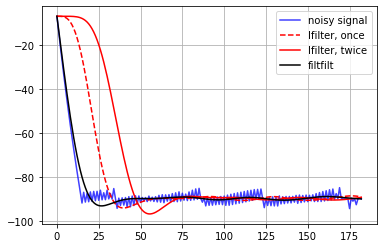

[ -6.8732866  -12.88507481 -18.89154914 -24.85035196 -30.71994713
 -36.46023706 -42.03315203 -47.40320513 -52.53800701 -57.40873447
 -61.99054687 -66.26294245 -70.21004569 -73.8208139  -77.08914935
 -80.01389954 -82.59872784 -84.85184397 -86.78560325 -88.41600092
 -89.76209432 -90.84538296 -91.6891732  -92.31795079 -92.75677988
 -93.03074357 -93.16443704 -93.18152213 -93.10434938 -92.95365049
 -92.74830053 -92.50514806 -92.23891271 -91.96214903 -91.68527184
 -91.41663896 -91.16268885 -90.92812387 -90.71611759 -90.52852391
 -90.36607757 -90.22858458 -90.11510209 -90.02410529 -89.95363816
 -89.90144593 -89.86508836 -89.84203487 -89.82974311 -89.82572309
 -89.82758919 -89.8331022  -89.84020297 -89.84703871 -89.85198287
 -89.85364931 -89.85090174 -89.84285942 -89.82890048 -89.80866285
 -89.78204163 -89.74918198 -89.7104677  -89.66650611 -89.61810998
 -89.56627685 -89.51216498 -89.45706599 -89.40237447 -89.34955526
 -89.30010861 -89.25553313 -89.2172873  -89.18675067 -89.16518546
 -89.15369

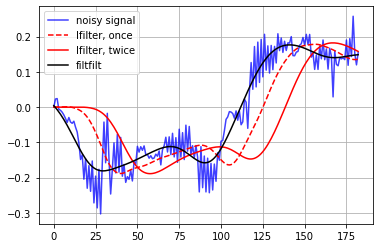

[ 0.00419264 -0.00123864 -0.00712617 -0.01347183 -0.02027047 -0.02750904
 -0.0351658  -0.04320977 -0.05160042 -0.06028748 -0.06921095 -0.07830142
 -0.08748069 -0.09666285 -0.10575588 -0.11466385 -0.12328965 -0.13153815
 -0.13931944 -0.14655199 -0.15316549 -0.15910321 -0.16432378 -0.16880245
 -0.1725317  -0.17552131 -0.17779781 -0.17940314 -0.18039249 -0.18083126
 -0.18079122 -0.18034617 -0.17956791 -0.17852299 -0.17727074 -0.17586227
 -0.17434018 -0.1727382  -0.17108107 -0.16938472 -0.16765685 -0.16589825
 -0.16410449 -0.16226798 -0.16038017 -0.15843345 -0.15642263 -0.15434577
 -0.15220454 -0.15000396 -0.14775168 -0.14545714 -0.14313058 -0.14078238
 -0.1384227  -0.13606149 -0.13370884 -0.13137555 -0.12907387 -0.12681816
 -0.12462549 -0.12251602 -0.12051313 -0.11864333 -0.11693591 -0.1154224
 -0.11413561 -0.11310858 -0.11237319 -0.11195892 -0.11189167 -0.11219268
 -0.11287758 -0.11395545 -0.11542802 -0.1172888  -0.11952233 -0.12210336
 -0.12499626 -0.12815452 -0.13152063 -0.1350262  -0.

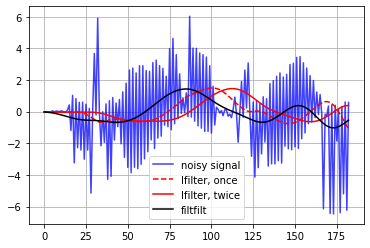

[-0.01580063 -0.02390481 -0.03412224 -0.0465891  -0.06140239 -0.07861229
 -0.09821482 -0.12014546 -0.14427407 -0.17040172 -0.19825953 -0.2275101
 -0.25775188 -0.28852679 -0.31933147 -0.34963258 -0.37888696 -0.40656711
 -0.43219082 -0.45535178 -0.47574683 -0.49319617 -0.50765626 -0.51922651
 -0.52814994 -0.53480713 -0.53970184 -0.54343745 -0.54668375 -0.55013121
 -0.55442845 -0.56010593 -0.5675036  -0.57672464 -0.58762926 -0.59986667
 -0.61292948 -0.62621266 -0.6390681  -0.65085209 -0.66096189 -0.66885756
 -0.67406823 -0.6761861  -0.67485446 -0.66975564 -0.66060293 -0.64713808
 -0.62913323 -0.60639567 -0.57877328 -0.54615955 -0.50849774 -0.4657841
 -0.4180706  -0.3654672  -0.3081435  -0.24632914 -0.18031247 -0.11043724
 -0.03709836  0.03926309  0.11816538  0.19909277  0.28150347  0.36483849
  0.44852995  0.53200759  0.61470345  0.69605543  0.77550996  0.85252407
  0.9265678   0.99712801  1.06371384  1.1258645   1.18315899  1.2352254
  1.28174642  1.32245846  1.35714393  1.38561798  1.40

In [34]:
filtered_roll =  filter_scipy(orientation_lb_test[headers_orient[0]])
filtered_pitch =  filter_scipy(orientation_lb_test[headers_orient[1]]) 
filtered_yaw =  filter_scipy(orientation_lb_test[headers_orient[2]])


filtered_roll_pd = pd.DataFrame(filtered_roll)
filtered_pitch_pd = pd.DataFrame(filtered_pitch)
filtered_yaw_pd = pd.DataFrame(filtered_yaw)
frame = pd.concat([filtered_roll_pd,filtered_pitch_pd,filtered_yaw_pd],axis = 1)


In [35]:
frame.columns = ["roll", "pitch", "yaw"]

In [36]:
frame

,roll,pitch,yaw
0,-6.873287,0.004193,-0.015801
1,-12.885075,-0.001239,-0.023905
2,-18.891549,-0.007126,-0.034122
3,-24.850352,-0.013472,-0.046589
4,-30.719947,-0.020270,-0.061402
...,...,...,...
178,-89.867025,0.146436,-0.838133
179,-89.911757,0.147125,-0.768644
180,-89.949027,0.147741,-0.694220
181,-89.979169,0.148277,-0.617826


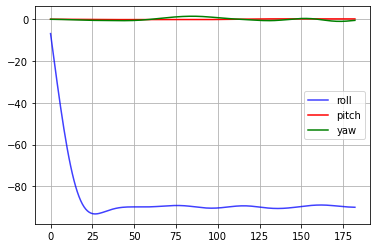

In [37]:
plt.figure
plt.plot(frame.index, frame['roll'], 'b', alpha=0.75)
plt.plot(frame.index, frame['pitch'], 'r', frame.index,  frame['yaw'], 'g')
plt.legend(('roll', 'pitch', 'yaw'), loc='best')
plt.grid(True)
plt.show()




In [ ]:
#(-0.02213089742574257, 0.01005698124752475, -0.013309934386138617)